# Classification of Iris Using MLP

In [5]:
import numpy as np
import pandas as pd
import warnings
from torch import nn
from torchsummaryX import summary
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)

In [6]:
#
# load the iris dataset as a dataframe.
#

df = pd.read_csv('my_data/iris.csv')

In [7]:
df.head()

,sepal_l,sepal_w,petal_l,petal_w,species
0,6.1,2.8,4.7,1.2,1
1,5.4,3.9,1.3,0.4,0
2,6.5,3.0,5.8,2.2,2
3,5.1,3.5,1.4,0.3,0
4,5.9,3.0,4.2,1.5,1


## Constructing PyTorch datasets

In [9]:
def make_dataset(df: pd.DataFrame) -> Dataset:
    # Extract features and target
    X = df.drop(columns=['species']).values
    Y = df['species'].values
    
    # Construct Tensors
    x = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(Y, dtype=torch.int64)
    
    dataset = TensorDataset(x, y)
    
    return dataset

In [10]:
train_dataset = make_dataset(df)
(x, y) = train_dataset[0]
print(f"First input {x}.  Its dtype must be {x.dtype}.")
print(f"First output {y}.  Its dtype must be {y.dtype}.")

First input tensor([6.1000, 2.8000, 4.7000, 1.2000]).  Its dtype must be torch.float32.
First output 1.  Its dtype must be torch.int64.


## Constructing PyTorch dataloader

In [11]:
def make_dataloader(dataset: Dataset, batch_size:int, shuffle:bool) -> DataLoader:
    loader = DataLoader(dataset, batch_size= batch_size, shuffle = shuffle, pin_memory= True)
    return loader

In [12]:
train_dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=5)
first_batch = next(iter(train_dataloader))
first_batch

[tensor([[6.1000, 2.8000, 4.7000, 1.2000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [6.5000, 3.0000, 5.8000, 2.2000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [5.9000, 3.0000, 4.2000, 1.5000]]),
 tensor([1, 0, 2, 0, 1])]

## Linear classifier

In [14]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3)

    def forward(self, x):
        return nn.functional.softmax(self.linear(x), dim=-1)

In [15]:
m = LinearClassifier()
summary(m, torch.zeros(32, 4));

         Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                
0_linear       [4, 3]      [32, 3]      15         12
-----------------------------------------------------
                      Totals
Total params              15
Trainable params          15
Non-trainable params       0
Mult-Adds                 12


## Training loop

In [17]:
def train(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=3)
    for epoch in range(epochs):
        for (x, target) in dataloader:
            pred = model(x)
            loss = cross_entropy(pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        metrics = {
            'epoch': epoch,
            'loss': loss.item(),
            'acc': accuracy(pred, target).item()
        }
        if epoch % (epochs // 10) == 0:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)
    return pd.DataFrame(history)

In [18]:
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)
linearclassifier = LinearClassifier()
optimizer = Adam(linearclassifier.parameters(), lr=0.1)
history_linear = train(linearclassifier, optimizer, dataloader, 100)

0: loss=0.8623, acc=0.77
10: loss=0.6475, acc=0.95
20: loss=0.6128, acc=0.95
30: loss=0.6003, acc=0.95
40: loss=0.5938, acc=0.95
50: loss=0.5899, acc=0.95
60: loss=0.5872, acc=0.95
70: loss=0.5853, acc=0.95
80: loss=0.5838, acc=0.95
90: loss=0.5827, acc=0.95


In [19]:
print("linear classifier acc > 50%?", history_linear.acc.iloc[-1] > 0.5)
print("linear classifier acc < 90%?", history_linear.acc.iloc[-1] < 0.9)

linear classifier acc > 50%? True
linear classifier acc < 90%? False


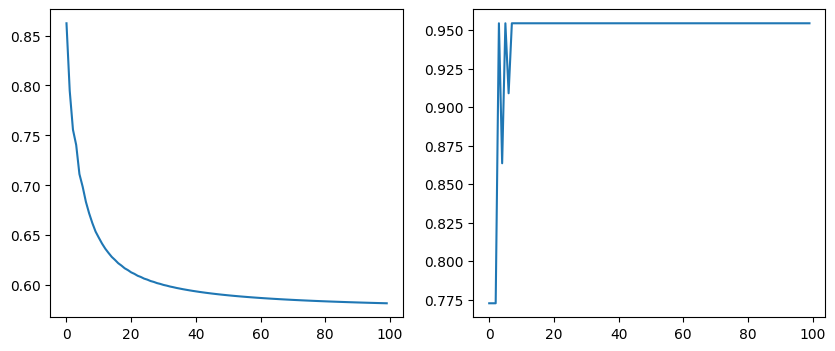

In [20]:
#
# Plotting the loss function and accuracy
#
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_linear.loss.plot.line(ax=axes[0])
history_linear.acc.plot.line(ax=axes[1]);

## MLP with hidden layer

In [21]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 100)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(100, 3)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.output(x)
        return x

In [22]:
m = MLPClassifier()
summary(m, torch.zeros(32, 4));

          Kernel Shape Output Shape Params Mult-Adds
Layer                                               
0_linear1     [4, 100]    [32, 100]  500.0     400.0
1_act1               -    [32, 100]      -         -
2_output      [100, 3]      [32, 3]  303.0     300.0
------------------------------------------------------
                      Totals
Total params           803.0
Trainable params       803.0
Non-trainable params     0.0
Mult-Adds              700.0


In [23]:
#
# training the MLP model
#
mlp = MLPClassifier()
optimizer = Adam(mlp.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)

history_mlp = train(mlp, optimizer, dataloader, 100)

0: loss=1.0589, acc=0.59
10: loss=0.5603, acc=0.82
20: loss=0.3798, acc=0.95
30: loss=0.2923, acc=0.95
40: loss=0.2337, acc=0.95
50: loss=0.1910, acc=0.95
60: loss=0.1592, acc=0.95
70: loss=0.1352, acc=0.95
80: loss=0.1170, acc=0.95
90: loss=0.1030, acc=0.95


In [24]:
history_mlp.acc.iloc[-1] > 0.9

True

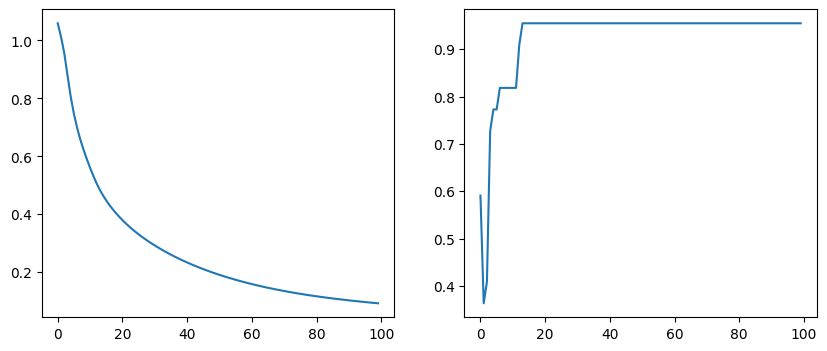

In [25]:
#
# Plotting the loss function and accuracy
#
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_mlp.loss.plot.line(ax=axes[0])
history_mlp.acc.plot.line(ax=axes[1]);

## MLP2DClassifier

In [26]:
class MLP2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 100)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 2)
        self.output = nn.Linear(2,3)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.output(x)
        return x
    
    def hiddenFeature(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

In [27]:
m = MLP2DClassifier()
summary(m, torch.zeros(32, 4));

          Kernel Shape Output Shape Params Mult-Adds
Layer                                               
0_linear1     [4, 100]    [32, 100]  500.0     400.0
1_act1               -    [32, 100]      -         -
2_linear2     [100, 2]      [32, 2]  202.0     200.0
3_output        [2, 3]      [32, 3]    9.0       6.0
------------------------------------------------------
                      Totals
Total params           711.0
Trainable params       711.0
Non-trainable params     0.0
Mult-Adds              606.0


In [28]:
mlp2 = MLP2DClassifier()
optimizer = Adam(mlp2.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)
history_mlp2 = train(mlp2, optimizer, dataloader, 100)

0: loss=1.1639, acc=0.41
10: loss=0.8174, acc=0.77
20: loss=0.5517, acc=0.82
30: loss=0.3938, acc=0.95
40: loss=0.3029, acc=0.95
50: loss=0.2347, acc=0.95
60: loss=0.1824, acc=0.95
70: loss=0.1437, acc=0.95
80: loss=0.1162, acc=0.95
90: loss=0.0970, acc=0.95


In [29]:
history_mlp2.acc.iloc[-1] > 0.9

True

In [30]:
#
# computing the hidden features for the first 100 training samples
#

(x, target) = train_dataset[0:100]
with torch.no_grad():
    x2 = mlp2.hiddenFeature(x)

In [31]:
x2.shape

torch.Size([100, 2])

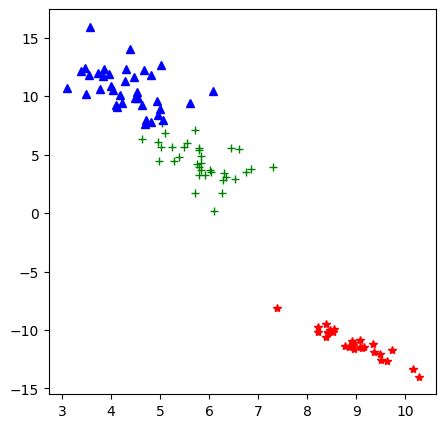

In [32]:
#
# Plotting the three species using their hidden features
#

I0 = target == 0
I1 = target == 1
I2 = target == 2

plt.figure(figsize=(5,5))
plt.plot(x2[I0, 0], x2[I0, 1], '*', color='red');
plt.plot(x2[I1, 0], x2[I1, 1], '+', color='green');
plt.plot(x2[I2, 0], x2[I2, 1], '^', color='blue');